This file is to test whether approx-SGM is a good approx or not.

It is a good approx (on Apr 24, 2023)(on Apr 24, 2023)

In [1]:
import sys
sys.path.append("../../mypkg")
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT, MIDRES_ROOT

In [2]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use(FIG_ROOT/"base.mplstyle")

In [38]:
import torch
from easydict import EasyDict as edict
from spectrome import Brain
from utils.misc import save_pkl, load_pkl
from sgm.sgm import SGM, network_transfer_local
from tqdm import tqdm

In [39]:
import numpy as np


def network_transfer_local1(C, D, parameters, w):
    """Network Transfer Function for spectral graph model for give freq w

    Args:
        brain (Brain): specific brain to calculate NTF
        parameters (dict): parameters for ntf. We shall keep this separate from Brain
        for now, as we want to change and update according to fitting.
        frequency (float): frequency at which to calculate NTF, in radias freq (not Hz)

    Returns:
        model_out (numpy asarray):  Each region's frequency response for
        the given frequency (w)
        frequency_response (numpy asarray):
        ev (numpy asarray): Eigen values
        Vv (numpy asarray): Eigen vectors

    """
    #C = brain.reducedConnectome
    #D = brain.distance_matrix

    
    parameters = np.asarray(parameters)
    alpha = parameters[0]
    gei =   parameters[1]  
    gii =   parameters[2]  
    tau_e = parameters[3]
    tauG =  parameters[4]
    tau_i = parameters[5]
    speed = parameters[6]
    gee = 1
    
    # Defining some other parameters used:
    zero_thr = 0.05
    nroi = C.shape[0]

    K = nroi

    d1, v = eig_search(speed, w/2/np.pi)
    d = eig_tC2L(alpha, d1)
    eig_ind = np.argsort(np.abs(d))  # sorting in ascending order and absolute value
    eig_vec = v[:, eig_ind]  # re-indexing eigen vectors according to sorted index
    eig_val = d[eig_ind]  # re-indexing eigen values with same sorted index

    eigenvalues = np.transpose(eig_val)
    eigenvectors = eig_vec[:, 0:K]

#     # Cortical model
    Fe = np.divide(1 / tau_e ** 2, (1j * w + 1 / tau_e) ** 2)
    Fi = np.divide(1 / tau_i ** 2, (1j * w + 1 / tau_i) ** 2)
    FG = np.divide(1 / tauG ** 2, (1j * w + 1 / tauG) ** 2)

    Hed = (1 + (Fe * Fi * gei)/(tau_e * (1j * w + Fi * gii/tau_i)))/(1j * w + Fe * gee/tau_e + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fi * gii / tau_i)))
    
    Hid = (1 - (Fe * Fi * gei)/(tau_i * (1j * w + Fe * gee/tau_e)))/(1j * w + Fi * gii/tau_i + (Fe * Fi * gei)**2/(tau_e * tau_i * (1j * w + Fe * gee / tau_e)))

    Htotal = Hed + Hid


#     q1 = (1j * w + 1 / tau_e * Fe * eigenvalues)
    q1 = (1j * w + 1 / tauG * FG * eigenvalues)
    qthr = zero_thr * np.abs(q1[:]).max()
    magq1 = np.maximum(np.abs(q1), qthr)
    angq1 = np.angle(q1)
    q1 = np.multiply(magq1, np.exp(1j * angq1))
    frequency_response = np.divide(Htotal, q1)
    
    model_out = 0

    for k in range(K):
        model_out += (frequency_response[k]) * np.outer(eigenvectors[:, k], np.conjugate(eigenvectors[:, k])) 
    model_out2 = np.linalg.norm(model_out,axis=1)

    
    return model_out2, frequency_response, eigenvalues, eigenvectors


class SGM1:
    def __init__(self, C, D, freqs, band="alpha"):
        self.freqs = freqs 
        self.C = C
        self.D = D
        if band == "alpha":
            self.freqband = np.where((freqs>=8) & (freqs<=12))[0]
        elif band == "beta":
            self.freqband = np.where((freqs>=13) & (freqs<=25))[0]
        else:
            self.freqband = np.arange(len(freqs))
            
    def run_local_coupling_forward(self, params):
        """run_forward. Function for running the forward model over the passed in range of frequencies,
        for the handed set of parameters (which must be passed in as a dictionary)
    
        Args:
            brain (Brain): An instance of the Brain class.
            #C = brain.reducedConnectome
            #D = brain.distance_matrix
            params (dict): Dictionary of a setting of parameters for the NTF model.
            freqs (array): Array of freqencies for which the model is to be calculated.
    
        Returns:
            array: Model values for each frequency, for each region of the brain, ordered as according to HCP
            (as in Brain class ordering).
    
        """
    
        eigenvalues = []
        eigenvectors = []
        frequency_response = []
        model_out = []
    
        for freq in self.freqs:
            w = 2 * np.pi * freq
            freq_model, freq_resp, eig_val, eig_vec = network_transfer_local1(
                self.C, self.D, params, w
            )
            frequency_response.append(freq_resp)
            eigenvalues.append(eig_val)
            eigenvectors.append(eig_vec)
            model_out.append(freq_model)
    
        frequency_response = np.asarray(frequency_response)
        eigenvalues = np.asarray(eigenvalues)
        eigenvectors = np.asarray(eigenvectors)
        model_out = np.transpose(np.asarray(model_out))
        
        return model_out
        # model_out: estimated PSD, raw
        
        


In [27]:
import netCDF4
fils = list(DATA_ROOT.glob("*s100tp.nc")) # 300/150
file2read = netCDF4.Dataset(fils[0], 'r')
psd_all = np.array(file2read.variables["__xarray_dataarray_variable__"][:])
time_points = np.array(file2read.variables["timepoints"][:])
freqs = np.array(file2read.variables["frequencies"][:])
ROIs_order = np.array(file2read.variables["regionx"][:])
file2read.close()

In [28]:
# Load the Connectome
brain = Brain.Brain()
brain.add_connectome(DATA_ROOT)
brain.reorder_connectome(brain.connectome, brain.distance_matrix)
brain.bi_symmetric_c()
brain.reduce_extreme_dir()

In [29]:
# some constant parameters for this file
paras = edict()

## I reorder them in an alphabetical order and I change tauC to tauG (Mar 27, 2023)
## the orginal order is taue, taui, tauC, speed, alpha, gii, gei
## paras.par_low = np.asarray([0.005,0.005,0.005,5, 0.1,0.001,0.001])
## paras.par_high = np.asarray([0.03, 0.20, 0.03,20,  1,    2,  0.7])
##

# alpha, gei, gii, taue, tauG, taui, speed 
paras.par_low = np.array([0.1, 0.001,0.001, 0.005, 0.005, 0.005, 5])
paras.par_high = np.asarray([1, 0.7, 2, 0.03, 0.03, 0.20, 20])
paras.prior_bds = np.array([paras.par_low, paras.par_high]).T
paras.names = ["alpha", "gei", "gii", "Taue", "TauG", "Taui", "Speed"]

paras.C = brain.reducedConnectome
paras.D = brain.distance_matrix
paras.freqs = freqs
paras.speed_grid = np.linspace(paras.par_low[-1], paras.par_high[-1], 200)

# Generate tilde C (once)

In [8]:
def obt_tC(w, speed):
    """
    The fn is calculate tC, note that L = I - alpha tC
    args: 
        w: in Hz
    """
    w = 2*np.pi*w
    C = paras.C
    D = paras.D
    
    # define sum of degrees for rows and columns for laplacian normalization
    rowdegree = np.transpose(np.sum(C, axis=1))
    coldegree = np.sum(C, axis=0)
    qind = rowdegree + coldegree < 0.2 * np.mean(rowdegree + coldegree)
    rowdegree[qind] = np.inf
    coldegree[qind] = np.inf
    nroi = C.shape[0]
    Tau = 0.001 * D / speed
    Cc = C * np.exp(-1j * Tau * w)
    L1 = np.identity(nroi)
    L2 = np.divide(1, np.sqrt(np.multiply(rowdegree, coldegree)) + np.spacing(1))
    tC = np.matmul(np.diag(L2), Cc)
    return tC

In [9]:
# generate the data beforehand (only noce)
pair_tb = edict()
pair_tb.speed = []
pair_tb.freq = []
pair_tb.name = []
flag = 0
for freq in tqdm(paras.freqs):
    for speed in paras.speed_grid:
        tC = obt_tC(freq, speed);
        d, v = np.linalg.eig(tC) 
        save_path = MIDRES_ROOT/"eig_pairs"/f"{flag+1}.pkl"
        save_pkl(save_path, [d, v], verbose=False, is_force=True)
        pair_tb.speed.append(speed)
        pair_tb.freq.append(freq)
        pair_tb.name.append(str(save_path))
        
        flag += 1
pair_tb_df = pd.DataFrame(pair_tb);
pair_tb_df.to_csv(MIDRES_ROOT/"eig_pairs/table.csv", index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 39/39 [02:17<00:00,  3.53s/it]


# Approximation check

In [30]:
pair_tb_df = pd.read_csv(MIDRES_ROOT/"eig_pairs/table.csv");
def eig_search(speed, w, df=pair_tb_df):
    dist = (df["freq"] - w)**2 + (df["speed"] - speed)**2;
    path = df.iloc[np.argmin(dist)]["name"]
    d, v = load_pkl(path, verbose=False)                                
    return d, v
def eig_tC2L(alpha, d):
    return 1-alpha*d

In [31]:
sgm1 = SGM1(paras.C, paras.D, paras.freqs);
sgm = SGM(paras.C, paras.D, paras.freqs);
dlt = np.diff(paras.speed_grid)[0]

0.07537688442211099

In [55]:
sgm_paras = np.array([0.5, 0.001,0.001, 0.005, 0.005, 0.005, 30])
sgm_paras = np.array([1, 0.7, 2, 0.03, 0.03, 0.20, paras.speed_grid[12]+dlt/2])
psd1 = sgm1.run_local_coupling_forward(sgm_paras);
psd = sgm.run_local_coupling_forward(sgm_paras);

In [56]:
import scipy
corrs = []
for ps, ps1 in zip(psd, psd1):
    corrs.append(scipy.stats.pearsonr(ps, ps1)[0])
np.min(corrs)

0.9999951836987628

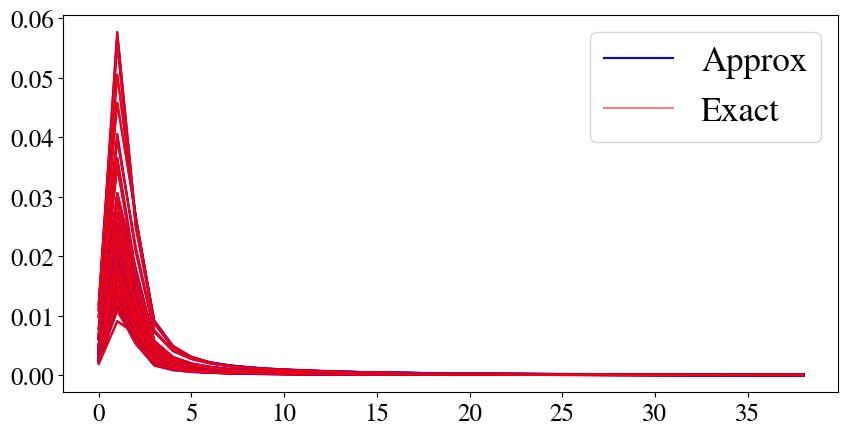

In [57]:
for ix in range(68):
    if ix == 0:
        plt.plot(psd1[ix], "blue", label="Approx")
        plt.plot(psd[ix], "red", label="Exact", alpha=0.5)
    else:
        plt.plot(psd1[ix], "blue")
        plt.plot(psd[ix], "red")
plt.legend()

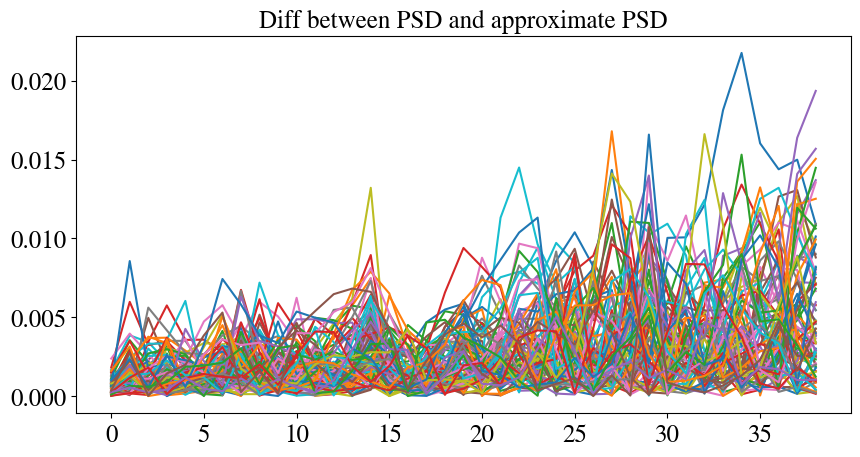

In [25]:
plt.title("Diff between PSD and approximate PSD")
for ix in range(86):
    plt.plot(np.abs(psd1[ix]-psd[ix])/np.abs(psd[ix]), label="diff")
#plt.legend()

# Speed check

In [33]:
%timeit psd1 = sgm1.run_local_coupling_forward(sgm_paras);

300 ms ± 77.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
%timeit  psd = sgm.run_local_coupling_forward(sgm_paras);

389 ms ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [45]:
%timeit network_transfer_local(paras.C, paras.D, sgm_paras, 2);

9.06 ms ± 905 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [46]:
%timeit network_transfer_local1(paras.C, paras.D, sgm_paras, 2);

8.47 ms ± 1.16 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
